In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_squared_error
import seaborn as sns
%matplotlib inline

df_listings = pd.read_csv('./data/boston_airbnb/listings.csv')

df_listings['price'] = df_listings.price.apply(lambda x: x.strip('$'))
df_listings['price']  =  pd.to_numeric(df_listings['price'] ,errors='coerce')

df_listings.price.head()

0    250.0
1     65.0
2     65.0
3     75.0
4     79.0
Name: price, dtype: float64

In [27]:
df = df_listings[['price','room_type','availability_30']]

df = df.dropna()

In [28]:
df.isnull().mean()

price              0.0
room_type          0.0
availability_30    0.0
dtype: float64

In [29]:
df.shape

(3573, 3)

In [30]:
df_cats = df_listings.select_dtypes(include=['object'])
print(df_cats.columns)

Index(['listing_url', 'last_scraped', 'name', 'summary', 'space',
       'description', 'experiences_offered', 'neighborhood_overview', 'notes',
       'transit', 'access', 'interaction', 'house_rules', 'thumbnail_url',
       'medium_url', 'picture_url', 'xl_picture_url', 'host_url', 'host_name',
       'host_since', 'host_location', 'host_about', 'host_response_time',
       'host_response_rate', 'host_acceptance_rate', 'host_is_superhost',
       'host_thumbnail_url', 'host_picture_url', 'host_neighbourhood',
       'host_verifications', 'host_has_profile_pic', 'host_identity_verified',
       'street', 'neighbourhood', 'neighbourhood_cleansed', 'city', 'state',
       'zipcode', 'market', 'smart_location', 'country_code', 'country',
       'is_location_exact', 'property_type', 'room_type', 'bed_type',
       'amenities', 'weekly_price', 'monthly_price', 'security_deposit',
       'cleaning_fee', 'extra_people', 'calendar_updated',
       'calendar_last_scraped', 'first_review', 'la

In [31]:
df.head()

,price,room_type,availability_30
0,250.0,Entire home/apt,0
1,65.0,Private room,26
2,65.0,Private room,19
3,75.0,Private room,6
4,79.0,Private room,13


In [32]:
pd.get_dummies(df['room_type'])


,Entire home/apt,Private room,Shared room
0,1,0,0
1,0,1,0
2,0,1,0
3,0,1,0
4,0,1,0
...,...,...,...
3580,0,1,0
3581,0,1,0
3582,1,0,0
3583,0,1,0


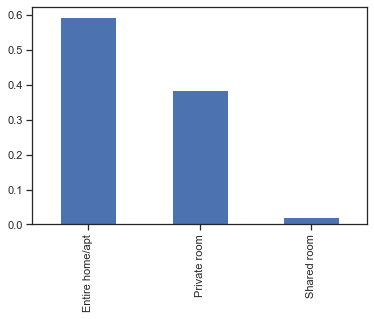

In [33]:
vals = df_listings['room_type'].value_counts()
((vals[:20])/df_listings.shape[0]).plot(kind="bar");

In [34]:
df  = df.dropna(subset=['price'], axis=0)
cat_df = df.select_dtypes(include=['object'])
cat_cols_lst = cat_df.columns
print(cat_cols_lst)

Index(['room_type'], dtype='object')


In [35]:
def create_dummy_df(df, cat_cols, dummy_na):
    for col in  cat_cols:
        try:
            df = pd.concat([df.drop(col, axis=1), pd.get_dummies(df[col], prefix=col, prefix_sep='_', drop_first=True, dummy_na=dummy_na)], axis=1)
        except:
            continue
            
    return df

In [36]:
def clean_fit_linear_mod(df, response_col, cat_cols, dummy_na, test_size=.3, rand_state=42):

    df  = df.dropna(subset=[response_col], axis=0)

    df = df.dropna(how='all', axis=1)

    df = create_dummy_df(df, cat_cols, dummy_na)

    fill_mean = lambda col: col.fillna(col.mean())

    df = df.apply(fill_mean, axis=0)

    X = df.drop(response_col, axis=1)
    y = df[response_col]
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=rand_state)

    lm_model = LinearRegression(normalize=True) 
    lm_model.fit(X_train, y_train)

    y_test_preds = lm_model.predict(X_test)
    y_train_preds = lm_model.predict(X_train)

    test_score = r2_score(y_test, y_test_preds)
    train_score = r2_score(y_train, y_train_preds)
    
    return test_score, train_score, lm_model, X_train, X_test, y_train, y_test


test_score, train_score, lm_model, X_train, X_test, y_train, y_test = clean_fit_linear_mod(df, 'price', cat_cols_lst, dummy_na=False)

In [37]:
print(test_score)
print(train_score)


0.35361611570978535
0.33961203553032626


In [38]:
def coef_weights(coefficients, X_train):
    coefs_df = pd.DataFrame()
    coefs_df['est_int'] = X_train.columns
    coefs_df['coefs'] = lm_model.coef_
    coefs_df['abs_coefs'] = np.abs(lm_model.coef_)
    coefs_df = coefs_df.sort_values('abs_coefs', ascending=False)
    return coefs_df

#Use the function
coef_df = coef_weights(lm_model.coef_, X_train)

#A quick look at the top results
coef_df.head()

,est_int,coefs,abs_coefs
2,room_type_Shared room,-143.601735,143.601735
1,room_type_Private room,-124.974167,124.974167
0,availability_30,1.780663,1.780663


In [39]:
print(X_train)


      availability_30  room_type_Private room  room_type_Shared room
845                20                       1                      0
1542               24                       0                      0
3465                0                       1                      0
1730                0                       0                      0
1931                8                       1                      0
...               ...                     ...                    ...
1132               24                       0                      0
1297               15                       0                      0
861                 6                       1                      0
3519               15                       0                      0
3185                0                       0                      0

[2501 rows x 3 columns]


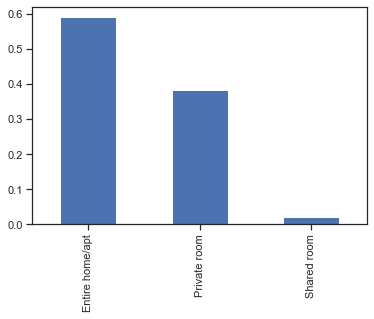

In [41]:
vals = df['room_type'].value_counts()
((vals[:20])/df_listings.shape[0]).plot(kind="bar");

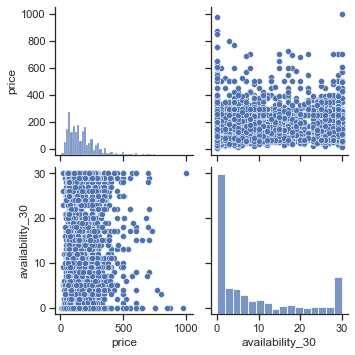

In [42]:
sns.set_theme(style="ticks")
sns.pairplot(df)

In [43]:
df.head()


,price,room_type,availability_30
0,250.0,Entire home/apt,0
1,65.0,Private room,26
2,65.0,Private room,19
3,75.0,Private room,6
4,79.0,Private room,13


In [44]:
df_2 = create_dummy_df(df, cat_cols_lst, True)
df_2.head()

,price,availability_30,room_type_Private room,room_type_Shared room,room_type_nan
0,250.0,0,0,0,0
1,65.0,26,1,0,0
2,65.0,19,1,0,0
3,75.0,6,1,0,0
4,79.0,13,1,0,0


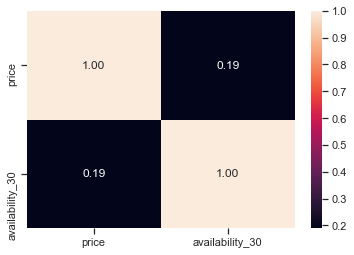

In [45]:
sns.heatmap(df.corr(), annot=True, fmt=".2f");